# Multi-Timescale Prediction

**Before we start**

- This tutorial is rendered from a Jupyter notebook that is hosted on GitHub. If you want to run the code yourself, you can find the notebook and configuration files [here](https://github.com/neuralhydrology/neuralhydrology/tree/master/examples/04-Multi-Timescale).
- To be able to run this notebook locally, you need to download the publicly available CAMELS US rainfall-runoff dataset and a publicly available extensions for hourly forcing and streamflow data. See the [Data Prerequisites Tutorial](data-prerequisites.nblink) for a detailed description on where to download the data and how to structure your local dataset folder. Note the special [section](data-prerequisites.nblink#Hourly-forcing-and-streamflow-data-for-CAMELS-US-basins)  with additional requirements for this tutorial.

This notebook showcases some ways to use the **MTS-LSTM** from our recent publication to generate predictions at multiple timescales: [**"Rainfall-Runoff Prediction at Multiple Timescales with a Single Long Short-Term Memory Network"**](https://hess.copernicus.org/articles/25/2045/2021/).


Let's assume we have a set of daily meteorological forcing variables and a set of hourly variables, and we want to generate daily and hourly discharge predictions.
Now, we could just go and train two separate LSTMs: One on the daily forcings to generate daily predictions, and one on the hourly forcings to generate hourly ones. 
One problem with this approach: It takes a _lot_ of time, even if you run it on a GPU. 
The reason is that the hourly model would crunch through a years' worth of hourly data to predict a single hour (assuming we provide the model input sequences with the same look-back that we usually use with daily data).
That's $365 \times 24 = 8760$ time steps to process for each prediction.
Not only does this take ages to train and evaluate, but also the training procedure becomes quite unstable and it is theoretically really hard for the model to learn dependencies over that many time steps.
What's more, the daily and hourly predictions might end up being inconsistent, because the two models are entirely unrelated.

## MTS-LSTM

MTS-LSTM solves these issues: We can use a single model to predict both hourly and daily discharge, and with some tricks, we can push the model toward predictions that are consistent across timescales.

### The Intuition

The basic idea of MTS-LSTM is this: we can process time steps that are far in the past at lower temporal resolution.
As an example, to predict discharge of September 10 9:00am, we'll certainly need fine-grained data for the previous few days or weeks.
We might also need information from several months ago, but we probably _don't_ need to know if it rained at 6:00am or 7:00am on May 15.
It's just so long ago that the fine resolution doesn't matter anymore.

### How it's Implemented

The MTS-LSTM architecture follows this principle: To predict today's daily and hourly dicharge, we start feeding daily meteorological information from up to a year ago into the LSTM.
At some point, say 14 days before today, we split our processing into two branches:
1. The first branch just keeps going with daily inputs until it outputs today's daily prediction.
So far, there's no difference to normal daily-only prediction.
2. The second branch is where it gets interesting: We take the LSTM state from 14 days before today, apply a linear transformation to it, and then use the resulting states as the starting point for another LSTM, which we feed the 14 days of _hourly_ data until it generates today's 24 hourly predictions.

Thus, in a single forward pass through the MTS-LSTM, we've generated both daily and hourly predictions.

If you prefer visualizations, here's what the architecture looks like:

![MTS-LSTM-Visualization.jpg](https://raw.githubusercontent.com/neuralhydrology/neuralhydrology/master/examples/04-Multi-Timescale/mtslstm.jpg)

You can see how the first 362 input steps are done at the daily timescale (the visualization uses 362 days, but in reality this is a tunable hyperparameter).
Starting with day 363, two things happen:
- The _daily_ LSTM just keeps going with daily inputs.
- We take the hidden and cell states from day 362 and pass them through a linear layer. Starting with these new states, the _hourly_ LSTM begins processing hourly inputs.

Finally, we pass the LSTMs' outputs through a linear output layer ($\text{FC}^H$ and $\text{FC}^D$) and get our predictions.

### Some Variations

Now that we have this model, we can think of a few variations:
1. Because the MTS-LSTM has an individual branch for each timescale, we can actually use a different forcings product at each timescale (e.g., daily Daymet and hourly NLDAS). Going even further, we can use _multiple_ sets of forcings at each timescale (e.g., daily Daymet and Maurer, but only hourly NLDAS). This can improve predictions a lot (see  [Kratzert et al., 2020](https://hess.copernicus.org/articles/25/2685/2021/hess-25-2685-2021.html)).
2. We could also use the same LSTM weights in all timescales' branches. We call this model the shared MTS-LSTM (sMTS-LSTM). In our results, the shared version generated slightly better predictions if all we have is one forcings dataset. The drawback is that the model doesn't support per-timescale forcings. Thus, if you have several forcings datasets, you'll most likely get better predictions if you use MTS-LSTM (non-shared) and leverage all your datasets.
3. We can link the daily and hourly predictions during training to nudge the model towards predictions that are consistent across timescales. We do this by means of a regularization of the loss function that increases the loss if the average daily prediction aggregated from hourly predictions does not match the daily prediction.

## Using MTS-LSTM

So, let's look at some code to train and evaluate an MTS-LSTM!
The following code uses the NeuralHydrology package to train an MTS-LSTM on daily and hourly discharge prediction.
For the sake of a quick example, we'll train our model on just a single basin. 
When you actually care about the quality of your predictions, you'll generally get much better model performance when training on hundreds of basins.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

Every experiment in NeuralHydrology uses a configuration file that specifies its setup. The config file for this example is called `1_basin.yml` and can be found in the same directory as this notebook file.
Let's look at some of the relevant configuration options:

In [2]:
run_config = Config(Path("1_basin.yml"))
print('model:\t\t', run_config.model)
print('use_frequencies:', run_config.use_frequencies)
print('seq_length:\t', run_config.seq_length)

model:		 mtslstm
use_frequencies: ['1H', '1D']
seq_length:	 {'1D': 365, '1H': 336}


`model` is obvious: We want to use the MTS-LSTM. For the sMTS-LSTM, we'd set `run_config.shared_mtslstm = True`.
In `use_frequencies`, we specify the timescales we want to predict.
In `seq_length`, we specify for each timescale the look-back window. Here, we'll start with 365 days look-back, and the hourly LSTM branch will get the last 14 days ($336/24 = 14$) at an hourly resolution.

As we're using the MTS-LSTM (and not sMTS-LSTM), we can use different input variables at each frequency.
Here, we use Maurer and Daymet as daily inputs, while the hourly model component uses NLDAS, Maurer, and Daymet.
Note that even though Daymet and Maurer are daily products, we can use them to support the hourly predictions.

In [3]:
print('dynamic_inputs:')
run_config.dynamic_inputs

dynamic_inputs:


{'1D': ['prcp(mm/day)_daymet',
  'srad(W/m2)_daymet',
  'tmax(C)_daymet',
  'tmin(C)_daymet',
  'vp(Pa)_daymet'],
 '1H': ['convective_fraction_nldas_hourly',
  'longwave_radiation_nldas_hourly',
  'potential_energy_nldas_hourly',
  'potential_evaporation_nldas_hourly',
  'pressure_nldas_hourly',
  'shortwave_radiation_nldas_hourly',
  'specific_humidity_nldas_hourly',
  'temperature_nldas_hourly',
  'total_precipitation_nldas_hourly',
  'wind_u_nldas_hourly',
  'wind_v_nldas_hourly',
  'prcp(mm/day)_daymet',
  'srad(W/m2)_daymet',
  'tmax(C)_daymet',
  'tmin(C)_daymet',
  'vp(Pa)_daymet']}

## Training

We start model training of our single-basin toy example with `start_run`.

**Note** 

- The config file assumes that the CAMELS US dataset is stored under `data/CAMELS_US` (relative to the main directory of this repository) or a symbolic link exists at this location. Make sure that this folder contains the required subdirectories `basin_mean_forcing`, `usgs_streamflow`, and `hourly`. If your data is stored at a different location and you can't or don't want to create a symbolic link, you will need to change the `data_dir` argument in the `1_basin.yml` config file that is located in the same directory as this notebook.
- By default, the config (`1_basin.yml`) assumes that you have a CUDA-capable NVIDIA GPU (see config argument `device`). In case you don't have any or you have one but one to train on the CPU, you can either change the config argument to `device: cpu` or pass `gpu=-1` to the `start_run()` function.

In [5]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2025-07-07 14:16:11,106: Logging to /Users/canruso/Desktop/UCB-USACE-LSTMs/examples/04-Multi-Timescale/runs/test_run_0707_141611/output.log initialized.
2025-07-07 14:16:11,107: ### Folder structure created at /Users/canruso/Desktop/UCB-USACE-LSTMs/examples/04-Multi-Timescale/runs/test_run_0707_141611
2025-07-07 14:16:11,108: ### Run configurations for test_run
2025-07-07 14:16:11,108: experiment_name: test_run
2025-07-07 14:16:11,109: use_frequencies: ['1H', '1D']
2025-07-07 14:16:11,110: train_basin_file: 1_basin.txt
2025-07-07 14:16:11,111: validation_basin_file: 1_basin.txt
2025-07-07 14:16:11,112: test_basin_file: 1_basin.txt
2025-07-07 14:16:11,112: train_start_date: 1999-10-01 00:00:00
2025-07-07 14:16:11,113: train_end_date: 2008-09-30 00:00:00
2025-07-07 14:16:11,114: validation_start_date: 1996-10-01 00:00:00
2025-07-07 14:16:11,114: validation_end_date: 1999-09-30 00:00:00
2025-07-07 14:16:11,114: test_start_date: 1989-10-01 00:00:00
2025-07-07 14:16:11,115: test_end_date: 1

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/hourlycamelsus.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').ffill()
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:396: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offsets = [(self.seq_len[i] - self._predict_last_n[i]) * to_offset(freq)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:403: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:555: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.cfg.autoregressive_inputs].resample(freq).mean()
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
2025-07-07 14:16:13,696: No specific hidden size for frequencies are specified. Same hidden size is used for all.


/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_ti

# Epoch 1: 100%|██████████| 11/11 [00:15<00:00,  1.37s/it, Loss: 0.7280]
2025-07-07 14:16:29,474: Epoch 1 average loss: avg_loss: 0.77177, avg_tie_frequencies: 0.07978, avg_total_loss: 0.85155
# Epoch 2: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, Loss: 0.6851]
2025-07-07 14:16:42,655: Epoch 2 average loss: avg_loss: 0.63290, avg_tie_frequencies: 0.04934, avg_total_loss: 0.68224
# Epoch 3: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it, Loss: 0.5404]
2025-07-07 14:16:56,439: Epoch 3 average loss: avg_loss: 0.53661, avg_tie_frequencies: 0.06334, avg_total_loss: 0.59994
# Epoch 4: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it, Loss: 0.5461]
2025-07-07 14:17:10,163: Epoch 4 average loss: avg_loss: 0.42733, avg_tie_frequencies: 0.07130, avg_total_loss: 0.49863
# Epoch 5: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it, Loss: 0.5855]
2025-07-07 14:17:23,701: Epoch 5 average loss: avg_loss: 0.36459, avg_tie_frequencies: 0.08226, avg_total_loss: 0.44685
# Validation:   0%|          | 0/1 

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/hourlycamelsus.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').ffill()
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:396: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offsets = [(self.seq_len[i] - self._predict_last_n[i]) * to_offset(freq)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:403: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  

# Validation: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
2025-07-07 14:17:25,489: Epoch 5 average validation loss: 0.34543 -- Median validation metrics: avg_loss: 0.28442, avg_tie_frequencies: 0.06100, NSE_1H: 0.49800, NSE_1D: 0.56503


/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 6:   9%|▉         | 1/11 [00:10<01:40, 10.04s/it, Loss: 0.5020]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 6: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, Loss: 0.4112]
2025-07-07 14:17:38,715: Epoch 6 average loss: avg_loss: 0.30982, avg_tie_frequencies: 0.07859, avg_total_loss: 0.38841
# Epoch 7: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it, Loss: 0.2673]
2025-07-07 14:17:51,471: Epoch 7 average loss: avg_loss: 0.28266, avg_tie_frequencies: 0.06682, avg_total_loss: 0.34948
# Epoch 8: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it, Loss: 0.4653]
2025-07-07 14:18:05,175: Epoch 8 average loss: avg_loss: 0.27053, avg_tie_frequencies: 0.07236, avg_total_loss: 0.34289
# Epoch 9: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, Loss: 0.3486]
2025-07-07 14:18:18,304: Epoch 9 average loss: avg_loss: 0.25456, avg_tie_frequencies: 0.07186, avg_total_loss: 0.32642
# Epoch 10: 100%|██████████| 11/11 [00:12<00:00,  1.18s/it, Loss: 0.2622]
2025-07-07 14:18:31,246: Epoch 10 average loss: avg_loss: 0.23895, avg_tie_frequencies: 0.06690, avg_total_loss: 0.30585
# Validation: 100%|██████████| 1/

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 11:   9%|▉         | 1/11 [00:10<01:43, 10.32s/it, Loss: 0.2714]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 11: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it, Loss: 0.2940]
2025-07-07 14:18:45,469: Epoch 11 average loss: avg_loss: 0.23199, avg_tie_frequencies: 0.06637, avg_total_loss: 0.29836
# Epoch 12: 100%|██████████| 11/11 [00:13<00:00,  1.27s/it, Loss: 0.3079]
2025-07-07 14:18:59,413: Epoch 12 average loss: avg_loss: 0.21964, avg_tie_frequencies: 0.06422, avg_total_loss: 0.28386
# Epoch 13: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it, Loss: 0.2989]
2025-07-07 14:19:14,122: Epoch 13 average loss: avg_loss: 0.20988, avg_tie_frequencies: 0.06803, avg_total_loss: 0.27791
# Epoch 14: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.3275]
2025-07-07 14:19:26,766: Epoch 14 average loss: avg_loss: 0.20705, avg_tie_frequencies: 0.06382, avg_total_loss: 0.27087
# Epoch 15: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it, Loss: 0.2364]
2025-07-07 14:19:39,592: Epoch 15 average loss: avg_loss: 0.18763, avg_tie_frequencies: 0.06460, avg_total_loss: 0.25223
# Validation: 100%|██████

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 16:   9%|▉         | 1/11 [00:10<01:41, 10.20s/it, Loss: 0.2161]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 16: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it, Loss: 0.2458]
2025-07-07 14:19:53,417: Epoch 16 average loss: avg_loss: 0.18963, avg_tie_frequencies: 0.06081, avg_total_loss: 0.25044
# Epoch 17: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it, Loss: 0.2255]
2025-07-07 14:20:06,332: Epoch 17 average loss: avg_loss: 0.17586, avg_tie_frequencies: 0.06750, avg_total_loss: 0.24336
# Epoch 18: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it, Loss: 0.2590]
2025-07-07 14:20:19,180: Epoch 18 average loss: avg_loss: 0.16898, avg_tie_frequencies: 0.05714, avg_total_loss: 0.22612
# Epoch 19: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it, Loss: 0.1879]
2025-07-07 14:20:32,117: Epoch 19 average loss: avg_loss: 0.16853, avg_tie_frequencies: 0.06286, avg_total_loss: 0.23139
# Epoch 20: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.2635]
2025-07-07 14:20:44,825: Epoch 20 average loss: avg_loss: 0.15820, avg_tie_frequencies: 0.06135, avg_total_loss: 0.21955
# Validation: 100%|██████

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 21:   9%|▉         | 1/11 [00:10<01:46, 10.63s/it, Loss: 0.1634]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 21: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it, Loss: 0.2595]
2025-07-07 14:20:59,653: Epoch 21 average loss: avg_loss: 0.16290, avg_tie_frequencies: 0.06380, avg_total_loss: 0.22670
# Epoch 22: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.1559]
2025-07-07 14:21:12,288: Epoch 22 average loss: avg_loss: 0.15716, avg_tie_frequencies: 0.06351, avg_total_loss: 0.22067
# Epoch 23: 100%|██████████| 11/11 [00:13<00:00,  1.18s/it, Loss: 0.1843]
2025-07-07 14:21:25,326: Epoch 23 average loss: avg_loss: 0.15181, avg_tie_frequencies: 0.06602, avg_total_loss: 0.21783
# Epoch 24: 100%|██████████| 11/11 [00:13<00:00,  1.22s/it, Loss: 0.2448]
2025-07-07 14:21:38,735: Epoch 24 average loss: avg_loss: 0.15276, avg_tie_frequencies: 0.06364, avg_total_loss: 0.21640
# Epoch 25: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it, Loss: 0.2249]
2025-07-07 14:21:51,660: Epoch 25 average loss: avg_loss: 0.14972, avg_tie_frequencies: 0.05844, avg_total_loss: 0.20817
# Validation: 100%|██████

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 26:   9%|▉         | 1/11 [00:09<01:37,  9.70s/it, Loss: 0.1794]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 26: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, Loss: 0.1625]
2025-07-07 14:22:05,256: Epoch 26 average loss: avg_loss: 0.16140, avg_tie_frequencies: 0.06444, avg_total_loss: 0.22584
# Epoch 27: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, Loss: 0.2263]
2025-07-07 14:22:18,363: Epoch 27 average loss: avg_loss: 0.15138, avg_tie_frequencies: 0.07189, avg_total_loss: 0.22327
# Epoch 28: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, Loss: 0.1508]
2025-07-07 14:22:31,436: Epoch 28 average loss: avg_loss: 0.15057, avg_tie_frequencies: 0.06682, avg_total_loss: 0.21739
# Epoch 29: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it, Loss: 0.2321]
2025-07-07 14:22:44,805: Epoch 29 average loss: avg_loss: 0.14588, avg_tie_frequencies: 0.06820, avg_total_loss: 0.21407
2025-07-07 14:22:44,813: Setting learning rate to 0.005
# Epoch 30: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it, Loss: 0.2734]
2025-07-07 14:22:58,496: Epoch 30 average loss: avg_loss: 0.14523, avg_tie_frequencies: 0.

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 31:   9%|▉         | 1/11 [00:10<01:44, 10.47s/it, Loss: 0.1333]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 31: 100%|██████████| 11/11 [00:13<00:00,  1.27s/it, Loss: 0.1227]
2025-07-07 14:23:12,866: Epoch 31 average loss: avg_loss: 0.14022, avg_tie_frequencies: 0.06811, avg_total_loss: 0.20833
# Epoch 32: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, Loss: 0.2048]
2025-07-07 14:23:26,093: Epoch 32 average loss: avg_loss: 0.13535, avg_tie_frequencies: 0.05821, avg_total_loss: 0.19355
# Epoch 33: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it, Loss: 0.2942]
2025-07-07 14:23:40,212: Epoch 33 average loss: avg_loss: 0.12867, avg_tie_frequencies: 0.05503, avg_total_loss: 0.18371
# Epoch 34: 100%|██████████| 11/11 [00:13<00:00,  1.18s/it, Loss: 0.2260]
2025-07-07 14:23:53,246: Epoch 34 average loss: avg_loss: 0.12907, avg_tie_frequencies: 0.05281, avg_total_loss: 0.18188
# Epoch 35: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.1809]
2025-07-07 14:24:05,867: Epoch 35 average loss: avg_loss: 0.12739, avg_tie_frequencies: 0.05510, avg_total_loss: 0.18249
# Validation: 100%|██████

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 36:   9%|▉         | 1/11 [00:09<01:34,  9.46s/it, Loss: 0.3338]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 36: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.1256]
2025-07-07 14:24:18,908: Epoch 36 average loss: avg_loss: 0.12547, avg_tie_frequencies: 0.05321, avg_total_loss: 0.17867
# Epoch 37: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.1878]
2025-07-07 14:24:31,564: Epoch 37 average loss: avg_loss: 0.12937, avg_tie_frequencies: 0.05835, avg_total_loss: 0.18772
# Epoch 38: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it, Loss: 0.2117]
2025-07-07 14:24:45,375: Epoch 38 average loss: avg_loss: 0.12623, avg_tie_frequencies: 0.06176, avg_total_loss: 0.18799
# Epoch 39: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, Loss: 0.1669]
2025-07-07 14:24:58,603: Epoch 39 average loss: avg_loss: 0.12854, avg_tie_frequencies: 0.05622, avg_total_loss: 0.18476
2025-07-07 14:24:58,609: Setting learning rate to 0.001
# Epoch 40: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it, Loss: 0.2578]
2025-07-07 14:25:13,034: Epoch 40 average loss: avg_loss: 0.12804, avg_tie_frequencies: 0.

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 41:   9%|▉         | 1/11 [00:10<01:40, 10.07s/it, Loss: 0.1165]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 41: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it, Loss: 0.1473]
2025-07-07 14:25:27,037: Epoch 41 average loss: avg_loss: 0.11465, avg_tie_frequencies: 0.05173, avg_total_loss: 0.16638
# Epoch 42: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it, Loss: 0.2176]
2025-07-07 14:25:39,764: Epoch 42 average loss: avg_loss: 0.11724, avg_tie_frequencies: 0.05028, avg_total_loss: 0.16753
# Epoch 43: 100%|██████████| 11/11 [00:16<00:00,  1.49s/it, Loss: 0.1788]
2025-07-07 14:25:56,170: Epoch 43 average loss: avg_loss: 0.11671, avg_tie_frequencies: 0.05499, avg_total_loss: 0.17170
# Epoch 44: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it, Loss: 0.2213]
2025-07-07 14:26:08,929: Epoch 44 average loss: avg_loss: 0.11636, avg_tie_frequencies: 0.05088, avg_total_loss: 0.16723
# Epoch 45: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it, Loss: 0.1052]
2025-07-07 14:26:22,257: Epoch 45 average loss: avg_loss: 0.10988, avg_tie_frequencies: 0.05091, avg_total_loss: 0.16079
# Validation: 100%|██████

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

# Epoch 46:   9%|▉         | 1/11 [00:10<01:45, 10.54s/it, Loss: 0.1514]

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


# Epoch 46: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it, Loss: 0.1428]
2025-07-07 14:26:36,795: Epoch 46 average loss: avg_loss: 0.11090, avg_tie_frequencies: 0.04684, avg_total_loss: 0.15775
# Epoch 47: 100%|██████████| 11/11 [00:14<00:00,  1.31s/it, Loss: 0.1018]
2025-07-07 14:26:51,244: Epoch 47 average loss: avg_loss: 0.10911, avg_tie_frequencies: 0.05096, avg_total_loss: 0.16007
# Epoch 48: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, Loss: 0.1743]
2025-07-07 14:27:04,374: Epoch 48 average loss: avg_loss: 0.11470, avg_tie_frequencies: 0.05156, avg_total_loss: 0.16626
# Epoch 49: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it, Loss: 0.1212]
2025-07-07 14:27:18,585: Epoch 49 average loss: avg_loss: 0.11253, avg_tie_frequencies: 0.05217, avg_total_loss: 0.16470
# Epoch 50: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, Loss: 0.2480]
2025-07-07 14:27:31,263: Epoch 50 average loss: avg_loss: 0.12047, avg_tie_frequencies: 0.05013, avg_total_loss: 0.17060
# Validation: 100%|██████

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

## Evaluation

Given the trained model, we can generate and evaluate its predictions. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name.

In [6]:
run_dir = Path("runs/test_run_0707_141611")  # you'll find this path in the output of the training above.

# create a tester instance and start evaluation
tester = get_tester(cfg=Config(run_dir / "config.yml"), run_dir=run_dir, period="test", init_model=True)
results = tester.evaluate(save_results=False, metrics=run_config.metrics)

results.keys()

2025-07-07 14:35:12,978: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2025-07-07 14:35:12,992: Using the model weights from runs/test_run_0707_141611/model_epoch050.pt


/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

# Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]2025-07-07 14:35:12,997: ## Warning: Hourly nldas_hourly NetCDF file not found. Falling back to slower csv files.


/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/hourlycamelsus.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').ffill()
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:396: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offsets = [(self.seq_len[i] - self._predict_last_n[i]) * to_offset(freq)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datasetzoo/basedataset.py:403: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  

# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:340: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_two = to_offset(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:265: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  'time_step': ((dates[freq][0, :] - dates[freq][0, -1]) / pd.Timedelta(freq)).astype(np.int64) +
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/evaluation/tester.py:277: FutureWarning: 'H' is deprecated and will be remov

dict_keys(['01022500'])

Let's take a closer look at the predictions and do some plots, starting with the daily results.
Note that units are mm/h even for daily values, since we predict daily averages.

/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/canruso/miniforge3/envs/ESDL_LSTM/lib/python3.10/site-packages/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


Daily metrics:
  NSE: 0.785
  MSE: 0.002
  RMSE: 0.050
  KGE: 0.796
  Alpha-NSE: 0.831
  Beta-KGE: 1.014
  Beta-NSE: 0.013
  Pearson-r: 0.888
  FHV: -19.078
  FMS: -10.872
  FLV: 33.183
  Peak-Timing: 0.625
  Peak-MAPE: 27.514


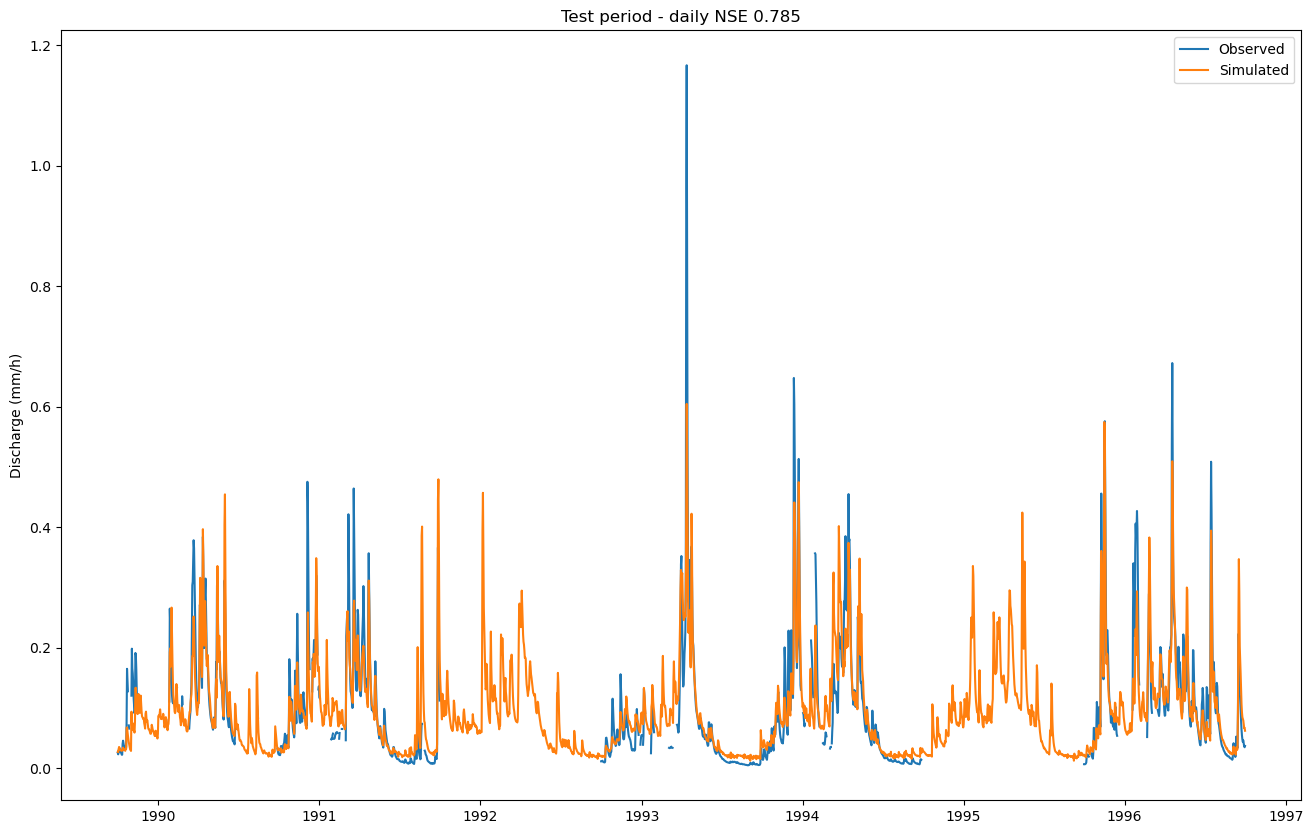

In [7]:
# extract observations and simulations
daily_qobs = results["01022500"]["1D"]["xr"]["QObs(mm/h)_obs"]
daily_qsim = results["01022500"]["1D"]["xr"]["QObs(mm/h)_sim"]

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(daily_qobs["date"], daily_qobs, label="Observed")
ax.plot(daily_qsim["date"], daily_qsim, label="Simulated")
ax.legend()
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - daily NSE {results['01022500']['1D']['NSE_1D']:.3f}")

# Calculate some metrics
values = metrics.calculate_all_metrics(daily_qobs.isel(time_step=-1), daily_qsim.isel(time_step=-1))
print("Daily metrics:")
for key, val in values.items():
    print(f"  {key}: {val:.3f}")

...and finally, let's look more closely at the last few months' hourly predictions:

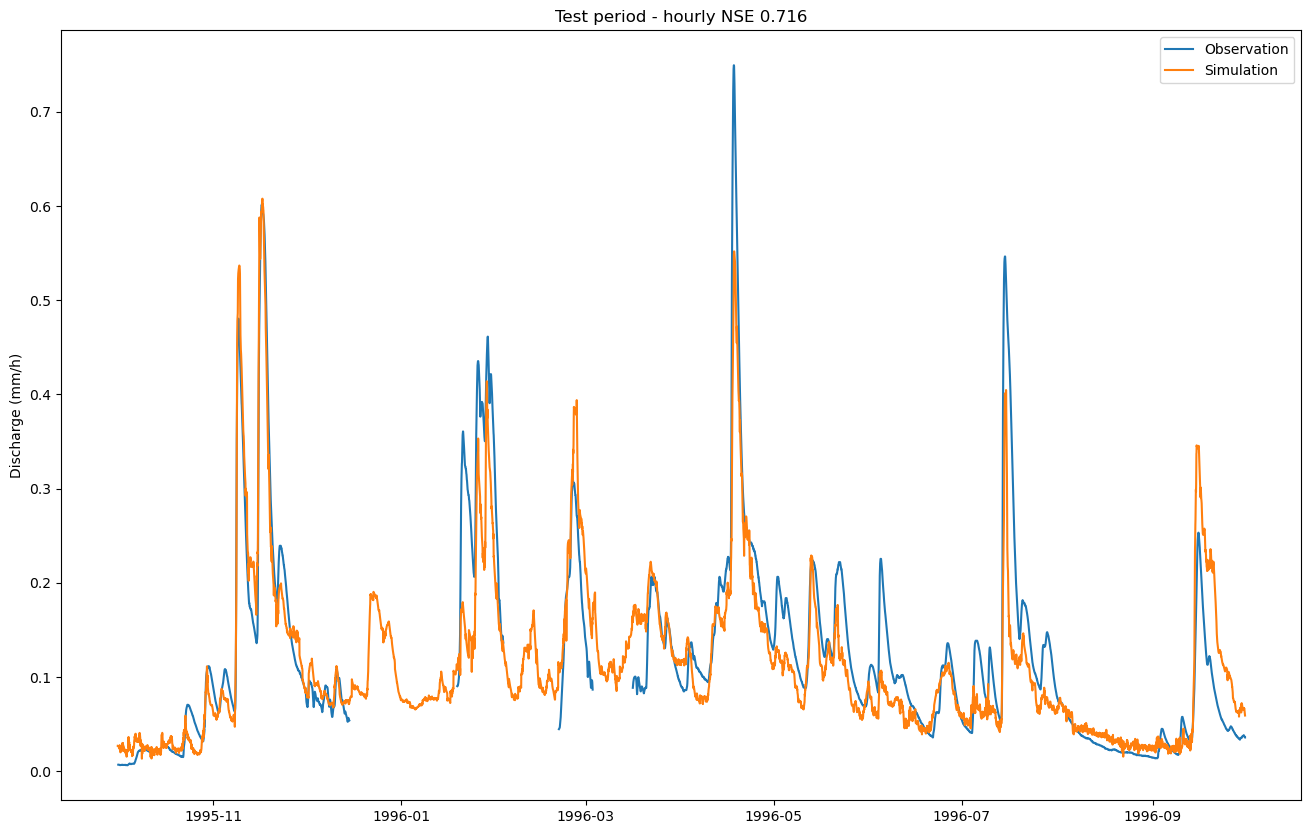

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Extract a date slice of observations and simulations
hourly_xr = results["01022500"]["1H"]["xr"].sel(date=slice("10-1995", None))

# 2) Select the last 24 steps (hours), then stack into a temporary dim 'z'
hourly = hourly_xr.isel(time_step=slice(-24, None)) \
    .stack(z=['date', 'time_step'])

# 3) Build a true datetime64 coordinate along 'z'
dt = (
        pd.to_datetime(hourly['date'].astype(str).values)
        + pd.to_timedelta(hourly['time_step'].values, unit='h')
)
hourly = hourly.assign_coords(datetime=('z', dt))

# 4) Swap dims so that 'datetime' becomes your sole index, and drop old coords
hourly = hourly.swap_dims({'z': 'datetime'}).drop_vars(['date', 'time_step'])

# 5) Pull out the two series you want to plot
hourly_qobs = hourly["QObs(mm/h)_obs"]
hourly_qsim = hourly["QObs(mm/h)_sim"]

# 6) Plot
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(hourly_qobs['datetime'], hourly_qobs, label="Observation")
ax.plot(hourly_qsim['datetime'], hourly_qsim, label="Simulation")
ax.set_ylabel("Discharge (mm/h)")
ax.set_title(f"Test period - hourly NSE {results['01022500']['1H']['NSE_1H']:.3f}")
ax.legend()
plt.show()